<a href="https://colab.research.google.com/github/polinauni/IntroToCL/blob/main/CL_Final_project_Bogdanova_Multilingual_paraphrase_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project

In [1]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install bertviz transformers
!pip install accelerate --upgrade

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("FacebookAI/xlm-roberta-base")
print(tokenizer)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaTokenizerFast(name_or_path='FacebookAI/xlm-roberta-base', vocab_size=250002, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	250001: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}
)


In [2]:
from datasets import load_dataset, DatasetDict
from transformers import DataCollatorWithPadding

ds_de = load_dataset("google-research-datasets/paws-x", "de")
ds_en = load_dataset("google-research-datasets/paws-x", "en")

print(ds_de)
print(ds_en)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 49401
    })
    test: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 2000
    })
})
DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 49401
    })
    test: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 2000
    })
})


In [3]:
# In order to do multilungual and initially cross-linguag (on the test) paraphrase detection,
# it is necessary to concatenate English and German data sets

from datasets import concatenate_datasets # Concatination step just stack data sets on top of each other

# Concatenate the 'train' splits from English and German
train_combined = concatenate_datasets([ds_en['train'], ds_de['train']])

# Concatenate the 'validation' splits
validation_combined = concatenate_datasets([ds_en['validation'], ds_de['validation']])

# Concatenate the 'test' splits
test_combined = concatenate_datasets([ds_en['test'], ds_de['test']])

# Shuffle each split so that examples from EN and DE are mixed
train_combined = train_combined.shuffle(seed=42)
validation_combined = validation_combined.shuffle(seed=42)
test_combined = test_combined.shuffle(seed=42)

# Store everything in a single DatasetDict
ds_combined = DatasetDict({
    'train': train_combined,
    'validation': validation_combined,
    'test': test_combined
})

print(ds_combined)

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 98802
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 4000
    })
})


For the first training, I decided to go with only 500 examples in the training set.

In [4]:
# Subset the dataset to 500 training examples, 200 for validation/test

ds_combined['train'] = ds_combined['train'].shuffle(seed=42).select(range(500))
ds_combined['validation'] = ds_combined['validation'].shuffle(seed=42).select(range(200))
ds_combined['test'] = ds_combined['test'].shuffle(seed=42).select(range(200))

In [ ]:
# Print out the first 10 examples from the train dataset to verify correctness
ds_combined["train"][:10]

{'id': [47656, 42988, 45490, 7261, 24058, 16674, 47043, 16686, 47071, 48420],
 'sentence1': ['Stefan Mross präsentierte im August 2010 eine Episode, während Axel Bulthaupt aus privaten Gründen abwesend war.',
  'This species is regularly caught along the coasts of Sicily , Italy , Greece , Crete , France , Turkey , and Spain .',
  'Jimmy Wareing was born in Silloth in 1917 and played rugby union for Silloth and Cumberland before the war .',
  'The SSSI has an area of 190.3 hectares , while the SAC comprises 168.3 hectares .',
  'The Cărbunele River or Rădocheasa River is a tributary of the Rădoteasa River in Romania .',
  'In the 2006-07 season , Goldwire played with Panellinios from the Greek Basketball League and joined the Spanish Club CB Girona in 2009 .',
  'Es ist wichtig, das Quantenregime des mechanischen Oszillators zu erreichen, bei dem thermische Rauscheffekte auf dem Bauelement vernachlässigbar werden.',
  'Ansong war seine Karriere bei Great Olympics und hier unterschrieb 

In [8]:
# We need to preprocess the data for training

def tokenize_function(examples):
    return tokenizer(
        examples["sentence1"],
        examples["sentence2"],
        padding='max_length',
        truncation=True,
        max_length=128 # Token leght for truncation and handling too long sentences
    )

small_tokenized_dataset = ds_combined.map(tokenize_function, batched=True)

# rename 'label' to 'labels' > better for BERT like models that expect this namimg
small_tokenized_dataset = small_tokenized_dataset.rename_column("label", "labels")

# set format for PyTorch
small_tokenized_dataset.set_format("torch")

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# Check what the first two sequences look like

small_tokenized_dataset['train'][0:2]

{'id': tensor([47656, 42988]),
 'sentence1': ['Stefan Mross präsentierte im August 2010 eine Episode, während Axel Bulthaupt aus privaten Gründen abwesend war.',
  'This species is regularly caught along the coasts of Sicily , Italy , Greece , Crete , France , Turkey , and Spain .'],
 'sentence2': ['Im August 2010 präsentierte Axel Bulthaupt eine Episode, während Stefan Mross aus persönlichen Gründen abwesend war.',
  'This kind is regularly caught along the coasts of Sicily , Italy , Greece , Crete , France , Turkey and Spain .'],
 'labels': tensor([0, 1]),
 'input_ids': tensor([[     0,  36947,    276,   3666,      7, 172624,     13,    566,   8055,
            1532,    909,  53379,      4,  31005, 150033,  35935,     18, 129977,
            1312,   8629,     33, 124673,   1563,  88051,     71,   1631,      5,
               2,      2,   3370,   8055,   1532, 172624,     13, 150033,  35935,
              18, 129977,    909,  53379,      4,  31005,  36947,    276,   3666,
            

In [ ]:
# Specifyng all the trainig parameters
from transformers import DataCollatorWithPadding
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer
from transformers import set_seed

set_seed(123)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)
accuracy = evaluate.load("accuracy")


arguments = TrainingArguments(
    output_dir="/content/drive/MyDrive/finalproject/paraphrase_detection_1st",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=8,
    num_train_epochs=5,
    eval_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to='none',
    seed=123
)

def compute_metrics(eval_pred):
    """Called at the end of validation. Gives accuracy"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # calculates the accuracy
    return accuracy.compute(predictions=predictions, references=labels)


trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=small_tokenized_dataset['train'],
    eval_dataset=small_tokenized_dataset['validation'], # change to test when you do your final evaluation!
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-22-43c60d27ca8d>:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.711400,0.692197,0.550000
2,0.677400,0.684925,0.605000
3,0.699800,0.691387,0.590000
4,0.681600,0.691351,0.555000
5,0.662900,0.686651,0.590000


TrainOutput(global_step=160, training_loss=0.6906456589698792, metrics={'train_runtime': 331.2644, 'train_samples_per_second': 7.547, 'train_steps_per_second': 0.483, 'total_flos': 164444409600000.0, 'train_loss': 0.6906456589698792, 'epoch': 5.0})

In [ ]:
# Check for the label distribution in the train data set due to the poor accuracy of <61%
from collections import Counter
count_0 = 0
count_1 = 0

for label in small_tokenized_dataset["train"]["labels"]:
    if label == 0:
        count_0 += 1
    elif label == 1:
        count_1 += 1

print(f"Label 0: {count_0}")
print(f"Label 1: {count_1}")

Label 0: 262
Label 1: 238


# 2d Training

For the second training run I decided to increase the number of examples in the training set to ensure better generalization.

In [ ]:
train_combined = concatenate_datasets([ds_en['train'], ds_de['train']])

validation_combined = concatenate_datasets([ds_en['validation'], ds_de['validation']])

test_combined = concatenate_datasets([ds_en['test'], ds_de['test']])

train_combined = train_combined.shuffle(seed=42)
validation_combined = validation_combined.shuffle(seed=42)
test_combined = test_combined.shuffle(seed=42)

ds_combined = DatasetDict({
    'train': train_combined,
    'validation': validation_combined,
    'test': test_combined
})

print(ds_combined)


ds_combined['train'] = ds_combined['train'].shuffle(seed=42).select(range(2000))
ds_combined['validation'] = ds_combined['validation'].shuffle(seed=42).select(range(500))
ds_combined['test'] = ds_combined['test'].shuffle(seed=42).select(range(500))

def tokenize_function(examples):
    return tokenizer(
        examples["sentence1"],
        examples["sentence2"],
        padding='max_length',
        truncation=True,
        max_length=150
    )

small_tokenized_dataset = ds_combined.map(tokenize_function, batched=True)
small_tokenized_dataset = small_tokenized_dataset.rename_column("label", "labels")
small_tokenized_dataset.set_format("torch")

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 98802
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 4000
    })
})


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
print("Train size:", ds_combined["train"].num_rows)
print("Validation size:", ds_combined["validation"].num_rows)
print("Test size:", ds_combined["test"].num_rows)

Train size: 2000
Validation size: 500
Test size: 500


In [ ]:
from transformers import DataCollatorWithPadding
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer
from transformers import set_seed

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)
accuracy = evaluate.load("accuracy")

set_seed(24)

arguments = TrainingArguments(
    output_dir="/content/drive/MyDrive/finalproject/paraphrase_detection_2d",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=8,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to='none',
    seed=24
)

def compute_metrics(eval_pred):
    """Called at the end of validation. Gives accuracy"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # calculates the accuracy
    return accuracy.compute(predictions=predictions, references=labels)


trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=small_tokenized_dataset['train'],
    eval_dataset=small_tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<ipython-input-14-9e187dec5e8c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.690900,0.676854,0.600000
2,0.687300,0.683395,0.598000
3,0.678500,0.657531,0.612000
4,0.499100,0.529389,0.756000
5,0.330400,0.564564,0.782000
6,0.238200,0.598445,0.780000
7,0.190100,0.767082,0.800000
8,0.228500,0.790927,0.800000
9,0.141000,0.857173,0.798000
10,0.075900,0.938208,0.806000


TrainOutput(global_step=1250, training_loss=0.4003457310438156, metrics={'train_runtime': 970.6879, 'train_samples_per_second': 20.604, 'train_steps_per_second': 1.288, 'total_flos': 1541666340000000.0, 'train_loss': 0.4003457310438156, 'epoch': 10.0})

In [ ]:
# Model evaluation

results = trainer.predict(small_tokenized_dataset['validation'])
print("Validation results:", results.metrics)

Validation results: {'test_loss': 0.5293893218040466, 'test_accuracy': 0.756, 'test_runtime': 4.0393, 'test_samples_per_second': 123.785, 'test_steps_per_second': 7.922}


In [ ]:
results = trainer.predict(small_tokenized_dataset["test"])
print("Test results:", results.metrics)

Test results: {'test_loss': 0.4973869025707245, 'test_accuracy': 0.778, 'test_runtime': 3.7389, 'test_samples_per_second': 133.729, 'test_steps_per_second': 8.559}


# 3d Training

For the 3d training run, I decided to slighly increase training examples and batch size, as well as reduce the number of epochs.

In [ ]:
train_combined = concatenate_datasets([ds_en['train'], ds_de['train']])

validation_combined = concatenate_datasets([ds_en['validation'], ds_de['validation']])

test_combined = concatenate_datasets([ds_en['test'], ds_de['test']])

train_combined = train_combined.shuffle(seed=42)
validation_combined = validation_combined.shuffle(seed=42)
test_combined = test_combined.shuffle(seed=42)

ds_combined = DatasetDict({
    'train': train_combined,
    'validation': validation_combined,
    'test': test_combined
})

print(ds_combined)


ds_combined['train'] = ds_combined['train'].shuffle(seed=42).select(range(3000))
ds_combined['validation'] = ds_combined['validation'].shuffle(seed=42).select(range(500))
ds_combined['test'] = ds_combined['test'].shuffle(seed=42).select(range(500))

def tokenize_function(examples):
    return tokenizer(
        examples["sentence1"],
        examples["sentence2"],
        padding='max_length',
        truncation=True,
        max_length=150
    )

small_tokenized_dataset = ds_combined.map(tokenize_function, batched=True)
small_tokenized_dataset = small_tokenized_dataset.rename_column("label", "labels")
small_tokenized_dataset.set_format("torch")

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 98802
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 4000
    })
})


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer
from transformers import set_seed

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)
accuracy = evaluate.load("accuracy")

set_seed(34)

arguments = TrainingArguments(
    output_dir="/content/drive/MyDrive/finalproject/paraphrase_detection_3d",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=8,
    num_train_epochs=8,
    eval_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to='none',
    seed=34
)

def compute_metrics(eval_pred):
    """Called at the end of validation. Gives accuracy"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # calculates the accuracy
    return accuracy.compute(predictions=predictions, references=labels)

# from transformers import EarlyStoppingCallback > I had to comment it out as the training stopped after 6th epoch

# early_stopping = EarlyStoppingCallback(
#     early_stopping_patience=2,  # Stop after 'patience' epochs with no improvement
#     early_stopping_threshold=0.0  # How much improvement must be seen
#)


trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=small_tokenized_dataset['train'],
    eval_dataset=small_tokenized_dataset['validation'], # change to test when you do your final evaluation!
    tokenizer=tokenizer,
    data_collator=data_collator,
    #callbacks=[early_stopping],
    compute_metrics=compute_metrics
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-14-74ac4915bbc9>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.699900,0.683309,0.600000
2,0.710300,0.674353,0.600000
3,0.460200,0.597477,0.726000
4,0.410000,0.475084,0.808000
5,0.300700,0.561823,0.792000
6,0.236200,0.551234,0.830000
7,0.160500,0.590675,0.804000
8,0.147100,0.618556,0.816000


TrainOutput(global_step=752, training_loss=0.405737846059368, metrics={'train_runtime': 1116.731, 'train_samples_per_second': 21.491, 'train_steps_per_second': 0.673, 'total_flos': 1849999608000000.0, 'train_loss': 0.405737846059368, 'epoch': 8.0})

In [ ]:
results = trainer.predict(small_tokenized_dataset["test"])
print("Test results:", results.metrics)

Test results: {'test_loss': 0.5403727889060974, 'test_accuracy': 0.822, 'test_runtime': 3.9604, 'test_samples_per_second': 126.25, 'test_steps_per_second': 4.04}


#Searching for best HP with grid search

In [9]:
import itertools
import numpy as np
from transformers import TrainingArguments, Trainer, set_seed, AutoModelForSequenceClassification
import evaluate
from transformers import DataCollatorWithPadding

In [10]:
train_combined = concatenate_datasets([ds_en['train'], ds_de['train']])

validation_combined = concatenate_datasets([ds_en['validation'], ds_de['validation']])

test_combined = concatenate_datasets([ds_en['test'], ds_de['test']])

train_combined = train_combined.shuffle(seed=42)
validation_combined = validation_combined.shuffle(seed=42)
test_combined = test_combined.shuffle(seed=42)

ds_combined = DatasetDict({
    'train': train_combined,
    'validation': validation_combined,
    'test': test_combined
})

print(ds_combined)


ds_combined['train'] = ds_combined['train'].shuffle(seed=42).select(range(2000))
ds_combined['validation'] = ds_combined['validation'].shuffle(seed=42).select(range(500))
ds_combined['test'] = ds_combined['test'].shuffle(seed=42).select(range(500))

def tokenize_function(examples):
    return tokenizer(
        examples["sentence1"],
        examples["sentence2"],
        padding='max_length',
        truncation=True,
        max_length=150
    )

small_tokenized_dataset = ds_combined.map(tokenize_function, batched=True)
small_tokenized_dataset = small_tokenized_dataset.rename_column("label", "labels")
small_tokenized_dataset.set_format("torch")

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 98802
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 4000
    })
})


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [12]:
# HP grid
learning_rates = [2e-5, 3e-5]
weight_decays = [0.0, 0.01]
batch_sizes = [16, 32]
num_epochs_list = [5, 8]

accuracy = evaluate.load("accuracy")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


grid_search_results = []
grid_counter = 0

for lr in learning_rates:
    for wd in weight_decays:
        for bs in batch_sizes:
            for num_epochs in num_epochs_list:
                grid_counter += 1
                print(f"\n--- Grid Search Iteration {grid_counter} ---")
                print(f"Learning Rate: {lr}, Weight Decay: {wd}, Batch Size: {bs}, Epochs: {num_epochs}")

                output_dir = f"/content/drive/MyDrive/finalproject/grid_search/model_{grid_counter}"

                set_seed(42)

                model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)

                training_args = TrainingArguments(
                    output_dir=output_dir,
                    per_device_train_batch_size=bs,
                    per_device_eval_batch_size=bs,
                    logging_steps=8,
                    num_train_epochs=num_epochs,
                    eval_strategy="epoch",  # Evaluate at the end of each epoch
                    save_strategy="epoch",
                    learning_rate=lr,
                    weight_decay=wd,
                    load_best_model_at_end=True,
                    report_to='none',
                    seed=42
                )

                def compute_metrics(eval_pred):
                    logits, labels = eval_pred
                    predictions = np.argmax(logits, axis=-1)
                    return accuracy.compute(predictions=predictions, references=labels)

                trainer = Trainer(
                    model=model,
                    args=training_args,
                    train_dataset=small_tokenized_dataset['train'],
                    eval_dataset=small_tokenized_dataset['validation'],
                    tokenizer=tokenizer,
                    data_collator=data_collator,
                    compute_metrics=compute_metrics
                )

                trainer.train()

                eval_result = trainer.evaluate()
                print(f"Validation Evaluation Results: {eval_result}")

                grid_search_results.append({
                    "lr": lr,
                    "weight_decay": wd,
                    "batch_size": bs,
                    "num_epochs": num_epochs,
                    "eval_accuracy": eval_result.get("eval_accuracy", None)
                })


for result in grid_search_results:
    print(result)


--- Grid Search Iteration 1 ---
Learning Rate: 2e-05, Weight Decay: 0.0, Batch Size: 16, Epochs: 5


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-711ade9007e5>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.684900,0.678940,0.600000
2,0.675300,0.681630,0.538000
3,0.661900,0.654143,0.604000
4,0.538600,0.621432,0.660000
5,0.515600,0.671989,0.690000


Validation Evaluation Results: {'eval_loss': 0.6214318871498108, 'eval_accuracy': 0.66, 'eval_runtime': 4.5157, 'eval_samples_per_second': 110.725, 'eval_steps_per_second': 7.086, 'epoch': 5.0}

--- Grid Search Iteration 2 ---
Learning Rate: 2e-05, Weight Decay: 0.0, Batch Size: 16, Epochs: 8


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-711ade9007e5>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.685900,0.678146,0.600000
2,0.697900,0.673933,0.600000
3,0.695100,0.677201,0.600000
4,0.697900,0.683294,0.600000
5,0.680200,0.674907,0.604000
6,0.693200,0.689410,0.540000
7,0.655700,0.678275,0.574000
8,0.630400,0.732174,0.568000


Validation Evaluation Results: {'eval_loss': 0.6739334464073181, 'eval_accuracy': 0.6, 'eval_runtime': 4.6508, 'eval_samples_per_second': 107.508, 'eval_steps_per_second': 6.881, 'epoch': 8.0}

--- Grid Search Iteration 3 ---
Learning Rate: 2e-05, Weight Decay: 0.0, Batch Size: 32, Epochs: 5


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-711ade9007e5>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.693600,0.673596,0.600000
2,0.694700,0.691454,0.516000
3,0.706100,0.682151,0.580000
4,0.689900,0.678175,0.600000
5,0.694500,0.673582,0.600000


Validation Evaluation Results: {'eval_loss': 0.6735819578170776, 'eval_accuracy': 0.6, 'eval_runtime': 4.1363, 'eval_samples_per_second': 120.882, 'eval_steps_per_second': 3.868, 'epoch': 5.0}

--- Grid Search Iteration 4 ---
Learning Rate: 2e-05, Weight Decay: 0.0, Batch Size: 32, Epochs: 8


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-711ade9007e5>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.690700,0.678439,0.600000
2,0.696400,0.677469,0.600000
3,0.705600,0.672681,0.600000
4,0.686900,0.682591,0.596000
5,0.693700,0.683960,0.570000
6,0.668200,0.680167,0.570000
7,0.668000,0.661951,0.636000
8,0.634400,0.662212,0.594000


Validation Evaluation Results: {'eval_loss': 0.6619510054588318, 'eval_accuracy': 0.636, 'eval_runtime': 4.5117, 'eval_samples_per_second': 110.822, 'eval_steps_per_second': 3.546, 'epoch': 8.0}

--- Grid Search Iteration 5 ---
Learning Rate: 2e-05, Weight Decay: 0.01, Batch Size: 16, Epochs: 5


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-711ade9007e5>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.685500,0.678997,0.600000
2,0.572000,0.656847,0.638000
3,0.494500,0.502989,0.798000
4,0.331500,0.532068,0.810000
5,0.315800,0.607799,0.812000


Validation Evaluation Results: {'eval_loss': 0.5029894113540649, 'eval_accuracy': 0.798, 'eval_runtime': 4.0849, 'eval_samples_per_second': 122.403, 'eval_steps_per_second': 7.834, 'epoch': 5.0}

--- Grid Search Iteration 6 ---
Learning Rate: 2e-05, Weight Decay: 0.01, Batch Size: 16, Epochs: 8


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-711ade9007e5>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.685300,0.678997,0.600000
2,0.691200,0.675645,0.600000
3,0.680400,0.672088,0.610000
4,0.533200,0.583154,0.716000
5,0.380600,0.609905,0.782000
6,0.247200,0.659204,0.798000
7,0.219400,0.771581,0.796000
8,0.068600,0.846139,0.788000


Validation Evaluation Results: {'eval_loss': 0.5831542015075684, 'eval_accuracy': 0.716, 'eval_runtime': 4.1658, 'eval_samples_per_second': 120.026, 'eval_steps_per_second': 7.682, 'epoch': 8.0}

--- Grid Search Iteration 7 ---
Learning Rate: 2e-05, Weight Decay: 0.01, Batch Size: 32, Epochs: 5


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-711ade9007e5>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.691500,0.676572,0.600000
2,0.696000,0.683966,0.600000
3,0.700900,0.679495,0.600000


KeyboardInterrupt: 

Due to reaching limit of Google Drive space, I had to stop the grid search.

At the same time, it is possible to see that the grid search did not produce outstanding results, and the training set size and hyperparameters used for the 3d training still reaching the best accuracy results.

# Evaluation

In [13]:
import evaluate
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [15]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
mcc_metric = evaluate.load("matthews_correlation")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/finalproject/paraphrase_detection_3d/checkpoint-564")
tokenizer_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

eval_dataloader = DataLoader(small_tokenized_dataset['test'], batch_size=8)

fine_tuned_model.eval()

for batch in eval_dataloader:
    # Tokenize using the two sentence columns from your dataset
    inputs = tokenizer(
        batch['sentence1'],
        batch['sentence2'],
        padding=True,
        truncation=True,
        return_tensors='pt'
    )


    with torch.no_grad():
        outputs = fine_tuned_model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    accuracy_metric.add_batch(predictions=predictions, references=batch['labels'])
    f1_metric.add_batch(predictions=predictions, references=batch['labels'])
    mcc_metric.add_batch(predictions=predictions, references=batch['labels'])
    precision_metric.add_batch(predictions=predictions, references=batch['labels'])
    recall_metric.add_batch(predictions=predictions, references=batch['labels'])

results = {
    "accuracy": accuracy_metric.compute(),
    "f1": f1_metric.compute(average="binary"),
    "matthews_correlation": mcc_metric.compute(),
    "precision": precision_metric.compute(average="binary"),
    "recall": recall_metric.compute(average="binary")
}

print(results)

{'accuracy': {'accuracy': 0.856}, 'f1': {'f1': 0.8333333333333334}, 'matthews_correlation': {'matthews_correlation': 0.7066010242667826}, 'precision': {'precision': 0.8372093023255814}, 'recall': {'recall': 0.8294930875576036}}


Cross-lingual eveluation

In [46]:
checkpoint_path = "/content/drive/MyDrive/finalproject/paraphrase_detection_3d/checkpoint-564"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)
model.eval()

tokenizer_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

label_names = ["NO", "YES"]


test_pairs = [
    ("I love cats", "Ich liebe Katzen", "YES"),  # paraphrase
    ("Where is the library?", "Wo ist die Bibliothek?", "YES"),
    ("She is very happy", "Sie ist sehr glücklich", "YES"),
    ("The weather is nice today", "Heute ist das Wetter schön", "YES"),
    ("I enjoy reading books", "Ich lese gerne Bücher", "YES"),
    ("Can you help me?", "Kannst du mir bitte helfen?", "YES"),
    ("They are going to the cinema", "Sie gehen ins Kino", "YES"),
    ("He found a new job", "Er hat seinen Job gekündigt", "NO"), # not paraphrase
    ("He bought a new car", "Er hat sein Fahrrad verkauft", "NO"),
    ("The meeting starts at 3 PM", "Das Meeting wurde abgesagt", "NO"),
    ("She likes coffee", "Er trinkt Tee", "NO"),
    ("We are traveling to France", "Wir waren letztes Jahr in Spanien", "NO"),
    ("My brother is a doctor", "Meine Schwester studiert Kunst", "NO")
]

correct_predictions = 0

for idx, (sent1, sent2, expected) in enumerate(test_pairs):
    model_inputs = tokenizer(sent1, sent2, return_tensors="pt", truncation=True)

    with torch.no_grad():
        outputs = model(**model_inputs)
        logits = outputs.logits

    predicted_label_id = torch.argmax(logits, dim=-1).item()
    predicted_label_name = label_names[predicted_label_id]

    print(f"Example {idx+1}:")
    print(f"Sentence 1: {sent1}")
    print(f"Sentence 2: {sent2}")
    print(f"Predicted label: {predicted_label_name}  (Expected: {expected})\n")

    if predicted_label_name == expected:
        correct_predictions += 1

accuracy = correct_predictions / len(test_pairs)
print(accuracy)

Example 1:
Sentence 1: I love cats
Sentence 2: Ich liebe Katzen
Predicted label: YES  (Expected: YES)

Example 2:
Sentence 1: Where is the library?
Sentence 2: Wo ist die Bibliothek?
Predicted label: YES  (Expected: YES)

Example 3:
Sentence 1: She is very happy
Sentence 2: Sie ist sehr glücklich
Predicted label: YES  (Expected: YES)

Example 4:
Sentence 1: The weather is nice today
Sentence 2: Heute ist das Wetter schön
Predicted label: YES  (Expected: YES)

Example 5:
Sentence 1: I enjoy reading books
Sentence 2: Ich lese gerne Bücher
Predicted label: YES  (Expected: YES)

Example 6:
Sentence 1: Can you help me?
Sentence 2: Kannst du mir bitte helfen?
Predicted label: YES  (Expected: YES)

Example 7:
Sentence 1: They are going to the cinema
Sentence 2: Sie gehen ins Kino
Predicted label: YES  (Expected: YES)

Example 8:
Sentence 1: He found a new job
Sentence 2: Er hat seinen Job gekündigt
Predicted label: YES  (Expected: NO)

Example 9:
Sentence 1: He bought a new car
Sentence 2: Er

As seen on the 3 examples above, the model can also handle cross-lingual examples.

Confusion Matrix:
 [[248  35]
 [ 37 180]]


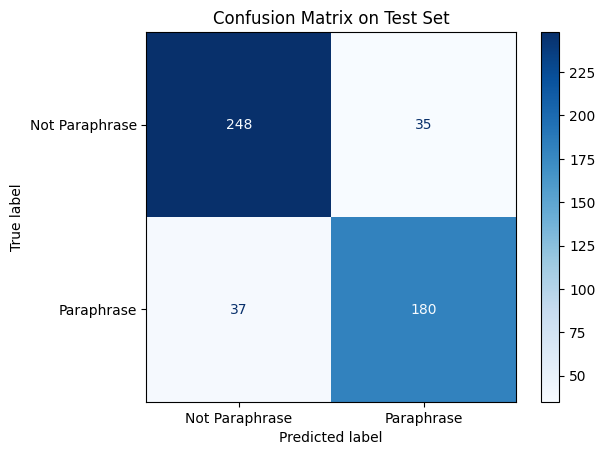

In [17]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/finalproject/paraphrase_detection_3d/checkpoint-564")
tokenizer_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

eval_dataloader = DataLoader(small_tokenized_dataset['test'], batch_size=8)

fine_tuned_model.eval()

all_predictions = []
all_true_labels = []

for batch in eval_dataloader:
    inputs = tokenizer(
        batch['sentence1'],
        batch['sentence2'],
        padding=True,
        truncation=True,
        return_tensors='pt'
    )


    with torch.no_grad():
        outputs = fine_tuned_model(**inputs)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    all_predictions.extend(predictions.cpu().numpy())
    all_true_labels.extend(batch['labels'] if isinstance(batch['labels'], list) else batch['labels'].cpu().numpy())

cm = confusion_matrix(all_true_labels, all_predictions)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Paraphrase", "Paraphrase"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()

In [32]:
# In order to better inspect the false positive and false negative examples, I would like to take a look at them

import pandas as pd

error_examples = []

for i in range(len(small_tokenized_dataset['test'])):
    example = small_tokenized_dataset['test'][i]

    inputs = tokenizer(
        example['sentence1'],
        example['sentence2'],
        padding=True,
        truncation=True,
        return_tensors='pt'
    )

    with torch.no_grad():
        outputs = fine_tuned_model(**inputs)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()
    true_label = example['labels']

    if prediction != true_label:
        error_examples.append({
            'id': example['id'],
            'sentence1': example['sentence1'],
            'sentence2': example['sentence2'],
            'true_label': true_label,
            'predicted_label': prediction,
            'sentence1_length': len(example['sentence1']),
            'sentence2_length': len(example['sentence2'])
        })

In [33]:
df_errors = pd.DataFrame(error_examples)
display(df_errors)

,id,sentence1,sentence2,true_label,predicted_label,sentence1_length,sentence2_length
0,tensor(6323),Ballouhey exists mainly in France in Isère and...,Ballouhey exists mainly in Paris in Isère and ...,tensor(0),1,86,84
1,tensor(6142),Das Licht im Louvre-Gemälde ist wärmer und sch...,Die Lichtverhältnisse im Louvre: Die Gemälde w...,tensor(1),0,124,129
2,tensor(2981),Die Tochter von Sumavalli hat sich in Gopalan ...,Nairs Tochter Sumavalli ist in Gopalan verliebt.,tensor(0),1,55,48
3,tensor(1603),"Er wurde in London, England, als Charles Wyndh...","Er wurde in London, England, geboren und starb...",tensor(1),0,104,92
4,tensor(6649),Two small independent leagues remain with only...,"Two small independent leagues remain , with on...",tensor(1),0,126,135
...,...,...,...,...,...,...,...
67,tensor(4112),Das Regiment verließ Philadelphia im Oktober 1...,Das Regiment verließ Philadelphia im Oktober 1...,tensor(1),0,155,149
68,tensor(7680),NS,Laut dem United States Census Bureau hat die S...,tensor(0),1,2,110
69,tensor(4545),A Peri whose power is in her hair appears in E...,"A peri , whose power appears in her hair , is ...",tensor(0),1,119,122
70,tensor(1029),"This film is about Rafael , a Malayalam singer...","The film is about Rafael , a new singer in Mal...",tensor(0),1,73,68


# Visualization

In [8]:
!pip install bertviz
!pip install bertviz transformers

In [12]:
from torch.utils.tensorboard import SummaryWriter
import re
import tensorflow as tf
import tensorboard as tb

In [10]:
from transformers import AutoModelForSequenceClassification

In [50]:
# Model loading for specific check points (epoch 6) - the best model

fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/finalproject/paraphrase_detection_3d/checkpoint-564"
)
#model_inputs = tokenizer(small_tokenized_dataset["test"]['sentence1']["sentence2"], padding=True, truncation=True, return_tensors="pt")
#print(len(small_tokenized_dataset["test"]))
num_examples = 100

small_test_dataset = small_tokenized_dataset["test"].shuffle(seed=42).select(range(num_examples))

sentence1_list = small_test_dataset["sentence1"]
sentence2_list = small_test_dataset["sentence2"]
labels_list    = small_test_dataset["labels"]

model_inputs = tokenizer(
    sentence1_list,
    sentence2_list,
    padding=True,
    truncation=True,
    max_length=150,
    return_tensors='pt'
)

outputs = fine_tuned_model(**model_inputs, output_hidden_states=True)

In [62]:
import torch
import os

all_hidden_states = outputs.hidden_states
num_layers = len(all_hidden_states)

path = "result_viz_roberta_1"


for layer in range(num_layers):
    layer_dir = os.path.join(path, f"layer_{layer}")
    os.makedirs(layer_dir, exist_ok=True)

    tensors = []
    labels = []

    for example in range(all_hidden_states[layer].shape[0]):
        cls_embedding = all_hidden_states[layer][example][0]
        tensors.append(cls_embedding)

        label = [
            sentence1_list[example],
            str(labels_list[example])
        ]
        labels.append(label)

    embeddings_tensor = torch.stack(tensors)

    writer = SummaryWriter(log_dir=layer_dir)
    writer.add_embedding(mat=embeddings_tensor, metadata=labels, metadata_header=['text', 'label'])

In [ ]:
!mv /content/result_viz_roberta_2 /content/drive/MyDrive/finalproject

In [13]:
# Model loading for specific check points (epoch 2)

fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/finalproject/paraphrase_detection_3d/checkpoint-188"
)
#model_inputs = tokenizer(small_tokenized_dataset["test"]['sentence1']["sentence2"], padding=True, truncation=True, return_tensors="pt")
#print(len(small_tokenized_dataset["test"]))
num_examples = 100

small_test_dataset = small_tokenized_dataset["test"].shuffle(seed=42).select(range(num_examples))

sentence1_list = small_test_dataset["sentence1"]
sentence2_list = small_test_dataset["sentence2"]
labels_list    = small_test_dataset["labels"]

model_inputs = tokenizer(
    sentence1_list,
    sentence2_list,
    padding=True,
    truncation=True,
    max_length=150,
    return_tensors='pt'
)

outputs = fine_tuned_model(**model_inputs, output_hidden_states=True)

In [14]:
import torch
import os

all_hidden_states = outputs.hidden_states
num_layers = len(all_hidden_states)

path = "result_viz_roberta_2"


for layer in range(num_layers):
    layer_dir = os.path.join(path, f"layer_{layer}")
    os.makedirs(layer_dir, exist_ok=True)

    tensors = []
    labels = []

    for example in range(all_hidden_states[layer].shape[0]):
        cls_embedding = all_hidden_states[layer][example][0]
        tensors.append(cls_embedding)

        label = [
            sentence1_list[example],
            str(labels_list[example])
        ]
        labels.append(label)

    embeddings_tensor = torch.stack(tensors)

    writer = SummaryWriter(log_dir=layer_dir)
    writer.add_embedding(mat=embeddings_tensor, metadata=labels, metadata_header=['text', 'label'])

In [9]:
# Model loading for specific check points (epoch 3)

fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/finalproject/paraphrase_detection_3d/checkpoint-282"
)
#model_inputs = tokenizer(small_tokenized_dataset["test"]['sentence1']["sentence2"], padding=True, truncation=True, return_tensors="pt")
#print(len(small_tokenized_dataset["test"]))
num_examples = 100

small_test_dataset = small_tokenized_dataset["test"].shuffle(seed=42).select(range(num_examples))

sentence1_list = small_test_dataset["sentence1"]
sentence2_list = small_test_dataset["sentence2"]
labels_list    = small_test_dataset["labels"]

model_inputs = tokenizer(
    sentence1_list,
    sentence2_list,
    padding=True,
    truncation=True,
    max_length=150,
    return_tensors='pt'
)

outputs = fine_tuned_model(**model_inputs, output_hidden_states=True)

In [13]:
import torch
import os

all_hidden_states = outputs.hidden_states
num_layers = len(all_hidden_states)

path = "result_viz_roberta_3"


for layer in range(num_layers):
    layer_dir = os.path.join(path, f"layer_{layer}")
    os.makedirs(layer_dir, exist_ok=True)

    tensors = []
    labels = []

    for example in range(all_hidden_states[layer].shape[0]):
        cls_embedding = all_hidden_states[layer][example][0]
        tensors.append(cls_embedding)

        label = [
            sentence1_list[example],
            str(labels_list[example])
        ]
        labels.append(label)

    embeddings_tensor = torch.stack(tensors)

    writer = SummaryWriter(log_dir=layer_dir)
    writer.add_embedding(mat=embeddings_tensor, metadata=labels, metadata_header=['text', 'label'])